# sai: spooky author identification
## analysis 2: refine simple practices

## strategy
The dataset is the training set.  The training set has three attributes: ID, author, and text class.  This is a multi-class text classification algorithm; this will determine the probability of who wrote which text based on the word usage and several machine learning algorithms.  

The strategy is to use the training set and perform two experiments.  Before performing the experiments, parameter tuning would be performed beforehand to save time and execution.  After that the two experiments are shown below.

The first experiment would include:

* Feature selection (split)
* Feature extraction (vectorize)
* Classification processing (fit/predict)
* Metrics (evaluate)
* Identification (identify)

Then the second experiment would include:

* Feature extraction (vectorize)
* Feature selection (split)
* Classification processing (fit/predict)
* Metrics (evaluate)
* Identification (identify)

Here, the first two are switch.  Vectorize the entire set and then perform classical machine learning.  This will be a good example.  

For now, the algorithmss are:
* vectorizer: CountVectorizer()
* classification: Naive Bayes (MultinomialNB()), Logistic Regression (LogisticsRegression())


| ALGORITHM | STEP | VECTORIZER | CLASSIFIER |
|---|---|---|---|
|1| A | CountVectorizer | MultinomialNB |
|2| B | CountVectorizer | MultinomialNB |
|3| A | CountVectorizer | LogisticRegression |
|4| B | CountVectorizer | LogisticRegression |


## code
### preliminaries
This is the 'de facto' run, where it loads libraries and necessary modules to perform the analysis.  Afterwards, it will read a simple csv file into a dataframe called 'texts.'  

In [1]:
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn
from sklearn.cross_validation import train_test_split             # cross-validation
from sklearn.feature_extraction.text import CountVectorizer       # vectorizer
from sklearn.feature_extraction.text import TfidfTransformer      # vectorizer
from sklearn.naive_bayes import MultinomialNB                     # classifier
from sklearn.linear_model import LogisticRegression               # classifier
from sklearn.model_selection import GridSearchCV                  # parameter tuning
from sklearn.pipeline import Pipeline                             # pipeline
from sklearn import metrics                                       # metrics

# other modules
from stop_words import get_stop_words
import string
from pprint import pprint


# Read training texts: texts
texts = pd.read_csv('train.csv')

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### exploratory data analysis
This explores the dataset imported.  The first analysis is size by author, or how many observations per author.  Notice how EAP (Edgar Allen Poe) has the most while HPL (HP Lovecraft) had over 5,600.  But the spread was not substantial; the maximum difference between Poe's prose and Lovecraft's were about 2,265.  MWS (Mary W Shelley) was in the middle.  This also created an arbitrary attribute, length, which will not help with identification but does provide an idea of whose words will weigh the most and how influential the bulk will be.

In [2]:
# Texts per author
texts.author.value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [3]:
# Texts size, test size
texts.groupby('author').describe()

id                       text         \
       count unique      top freq count unique   
author                                           
EAP     7900   7900  id24058    1  7900   7900   
HPL     5635   5635  id14804    1  5635   5635   
MWS     6044   6044  id08278    1  6044   6044   

                                                                
                                                      top freq  
author                                                          
EAP     In the street, next morning, my great, great, ...    1  
HPL     Apparently it was a point somewhere between Hy...    1  
MWS     Do you think that I will be questioned, and my...    1

In [4]:
texts['length'] = texts['text'].apply(len)
texts.head() 

,id,text,author,length
0,id26305,"This process, however, afforded me no means of...",EAP,231
1,id17569,It never once occurred to me that the fumbling...,HPL,71
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,200
3,id27763,How lovely is spring As we looked from Windsor...,MWS,206
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,174


In [5]:
texts.length.describe().apply(round)

count    19579
mean       149
std        107
min         21
25%         81
50%        128
75%        191
max       4663
Name: length, dtype: int64

In [6]:
texts.groupby('author').length.describe().transpose().apply(round)

author,EAP,HPL,MWS
count,7900.0,5635.0,6044.0
mean,142.0,156.0,152.0
std,106.0,82.0,126.0
min,21.0,21.0,21.0
25%,68.0,98.0,84.0
50%,115.0,142.0,130.0
75%,186.0,196.0,192.0
max,1533.0,900.0,4663.0


These length statistics may say little but still imply a lot.  All three will have text with no less than 21 words.  Also, 75% of the texts will contain about 190 words.  Between 75% and 100%, outliers will appear.  For instance, one of Mary Shelley's prose contains 4,663 words alone.  The histograms of the prose count by words is shown below, both as a total and by author.  

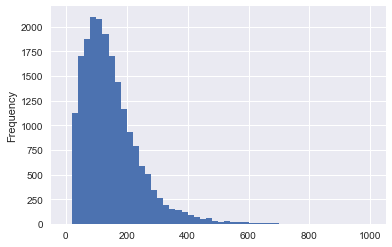

In [7]:
texts['length'].plot(bins=50,kind = 'hist',range=[0,1000])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d862710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a9eb940>]], dtype=object)

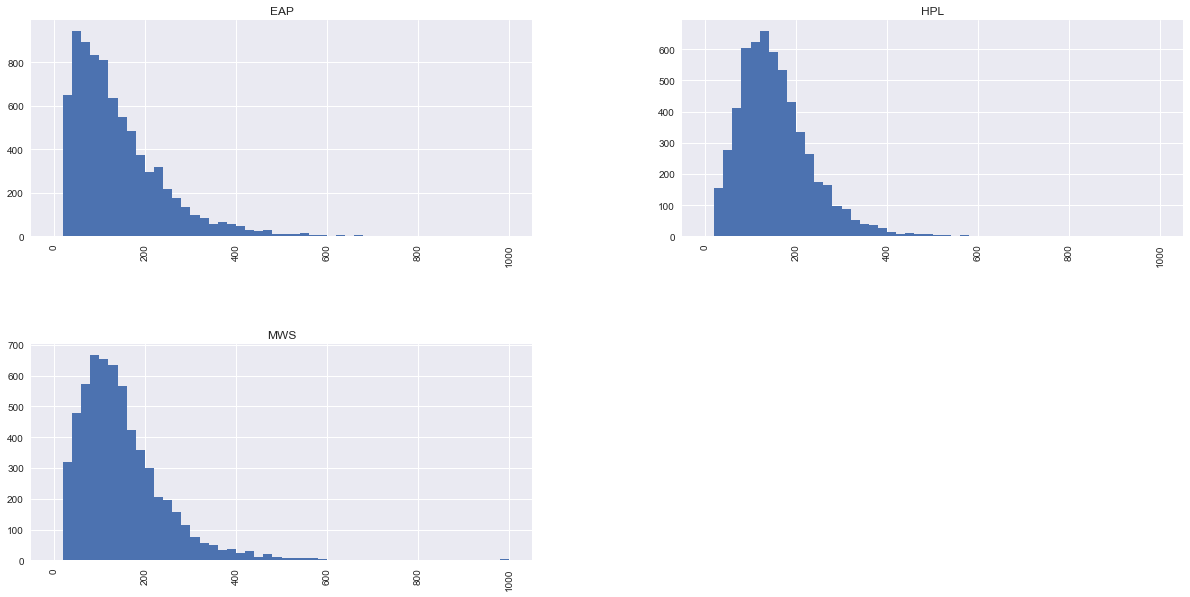

In [8]:
# plot length by author
texts.hist(column='length',by ='author',bins=50,figsize =(20,10),range=[0,1000])

## feature selection
Because the categories are small, the target data X will be the text prose and the target response y is the author.  In other words, this will identify the author by looking at the words the author uses.  Advanced features such as sentiment and others will be based on hyperparamater tuning! 

In [9]:
# choose X and y
X = texts.text
y = texts.author

## experiment 1 split & vectorize
The first method splits the training set between train and test data.  It will hold onto 70% for training.  First, it is important to tune the pipelines to see what would be the best combination for manipulating the data to get higher accuracy.  Two pipelines are performed: both with the same vectorizer but different classifiers.

### tune

In [17]:
# import stop words to reduce noise
stop_words = get_stop_words('en')

In [18]:
# pipeline
pipeline_A1 = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB()),
])

# parameters
parameters_A1 = dict(
    #vect__binary=[True, False], 
    vect__max_df = (0.5, 0.75, 1.0),
    vect__ngram_range = [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)],
    #vect__min_df=[0,1,2,3,4,5], # keep min_df default
    nb__alpha = [0.05, 0.1, 1.0, 2.0]
)

In [19]:
# cv=5 academically proven as best fold, kept n_jobs (jobs running parallel)= 1, output time
grid_search_A1 = GridSearchCV(pipeline_A1, 
                           parameters_A1, 
                           n_jobs=1, 
                           cv=5
                )

In [20]:
# fit model for best parameters
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_A1.steps])
print("parameters:")
pprint(parameters_A1, depth=2)

%time grid_search_A1.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search_A1.best_score_)
print("Best parameters set:")

best_parameters = grid_search_A1.best_estimator_.get_params()

for param_name in sorted(parameters_A1.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'nb']
parameters:
{'nb__alpha': [0.05, 0.1, 1.0, 2.0],
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': [(...), (...), (...), (...), (...), (...)]}
CPU times: user 15min 26s, sys: 23 s, total: 15min 49s
Wall time: 15min 52s
Best score: 0.846
Best parameters set:
	nb__alpha: 0.1
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In [80]:
# pipeline
pipeline_A2 = Pipeline([
    ('vect', CountVectorizer()),
    #('tfidf', TfidfTransformer()),
    ('logreg', LogisticRegression()),
])

# parameters
parameters_A2 = dict(
    #vect__binary=[True, False], 
    vect__max_df = (0.5, 0.75, 1.0),
    vect__ngram_range =  [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)],
    #vect__min_df=[0,1,2,3,4,5], # keep min_df default
    logreg__C = [0.05, 0.1, 1.0, 2.0], # positive float
)

In [81]:
# cv=5 academically proven as best fold, kept n_jobs (jobs running parallel)= 1, output time
grid_search_A2 = GridSearchCV(pipeline_A2, 
                           parameters_A2, 
                           n_jobs=1, 
                           cv=5
                )

In [82]:
# fit model to determine best parameters
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_A2.steps])
print("parameters:")
pprint(parameters_A2, depth=2)

%time grid_search_A2.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search_A2.best_score_)
print("Best parameters set:")

best_parameters = grid_search_A2.best_estimator_.get_params()

for param_name in sorted(parameters_A2.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'logreg']
parameters:
{'logreg__C': [0.05, 0.1, 1.0, 2.0],
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': [(...), (...), (...), (...), (...), (...)]}
CPU times: user 41min 19s, sys: 50.4 s, total: 42min 9s
Wall time: 22min 42s
Best score: 0.812
Best parameters set:
	logreg__C: 1.0
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


### split
Here, the training and test data are split using a popular sklearn function, with stratification important to avoid biased data manipulation.

In [95]:
# cross validation
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

---
### vectorize
This will use the CountVectorizer function with the hyperparameters provided.  

In [131]:
pipeline_1A = Pipeline([
    ('vect', CountVectorizer(binary=True, ngram_range=(1,2), stop_words=None, max_df=0.5)),
    #('tfidf', TfidfTransformer()),
    ('nb', MultinomialNB(alpha=0.1))
])

### fit and predict
Using the pipeline, fit with the training data and then test with the performing data.

In [132]:
pipeline_1A.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('nb', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])

In [155]:
y_pred_train = pipeline_1A.predict(X_train)

In [156]:
y_pred_test = pipeline_1A.predict(X_test)

### evaluation
Here, this will evaluate with three metrics: accuracy score, confusion matrix, and classification report.

In [157]:
print(metrics.accuracy_score(y_pred_train, y_train))

0.997275946609


In [158]:
print(metrics.accuracy_score(y_pred_test, y_test))

0.8582226762


In [159]:
print(metrics.confusion_matrix(y_pred_train, y_train))

[[5908    8    7]
 [   6 4211    1]
 [  11    7 4525]]


In [160]:
print(metrics.confusion_matrix(y_pred_test, y_test))

[[1664  130  122]
 [ 122 1202   54]
 [ 189   77 1335]]


In [161]:
print(metrics.classification_report(y_pred_train, y_train))

             precision    recall  f1-score   support

        EAP       1.00      1.00      1.00      5923
        HPL       1.00      1.00      1.00      4218
        MWS       1.00      1.00      1.00      4543

avg / total       1.00      1.00      1.00     14684



In [162]:
print(metrics.classification_report(y_pred_test,y_test))

             precision    recall  f1-score   support

        EAP       0.84      0.87      0.86      1916
        HPL       0.85      0.87      0.86      1378
        MWS       0.88      0.83      0.86      1601

avg / total       0.86      0.86      0.86      4895



In [163]:
exp1_A_lst1 = pipeline_1A.predict_proba(X_test)
exp1_A_lst2 = pipeline_1A.predict(X_test)

In [164]:
X_train_prob = pd.DataFrame(pipeline_1A.predict_proba(X_train), columns=['EAP','HPL','MWS'])

---
### vectorize w/ LogisticRegression()
This uses LogisticRegression() with the hyperparameter tuning mentioned above.

In [233]:
pipeline_1B = Pipeline([
    ('vect', CountVectorizer(binary=True, ngram_range=(1,1), stop_words=None, max_df=0.75)),
    #('tfidf', TfidfTransformer()),
    ('logreg', LogisticRegression(C=1.0)),
])

### fit and predict w/ LogisticRegression()
Fit the training set, apply it on the test set, and create a prediction model.

In [234]:
pipeline_1B.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [235]:
y_pred_train = pipeline_1B.predict(X_train)

In [236]:
y_pred_test = pipeline_1B.predict(X_test)

### evaluation w/ LogisticRegression()
Here, this will evaluate with three metrics: accuracy score, confusion matrix, and classification report.

In [237]:
print(metrics.accuracy_score(y_pred_train, y_train))

0.970239716698


In [238]:
print(metrics.accuracy_score(y_pred_test, y_test))

0.831664964249


In [239]:
print(metrics.confusion_matrix(y_pred_train, y_train))

[[5815  113  166]
 [  37 4092   27]
 [  73   21 4340]]


In [240]:
print(metrics.confusion_matrix(y_pred_test, y_test))

[[1719  209  216]
 [ 114 1123   66]
 [ 142   77 1229]]


In [241]:
print(metrics.classification_report(y_pred_train, y_train))

             precision    recall  f1-score   support

        EAP       0.98      0.95      0.97      6094
        HPL       0.97      0.98      0.98      4156
        MWS       0.96      0.98      0.97      4434

avg / total       0.97      0.97      0.97     14684



In [242]:
print(metrics.classification_report(y_pred_test,y_test))

             precision    recall  f1-score   support

        EAP       0.87      0.80      0.83      2144
        HPL       0.80      0.86      0.83      1303
        MWS       0.81      0.85      0.83      1448

avg / total       0.83      0.83      0.83      4895



In [243]:
exp1_A_lst3 = pipeline_1A.predict_proba(X_test)
exp1_A_lst4 = pipeline_1A.predict(X_test)

---
---

## experiment 2 vectorize & split
The second method takes the entire corpus and then splits the data.  Two pipelines are performed: both with the same vectorizer but different classifiers.

### tune
Like before, it will tune first.  Then it will apply it to fit and predict.  

In [176]:
# initiate the vectorizer
pipeline_B1 = Pipeline([
    ('vect', CountVectorizer()),
    ('nb', MultinomialNB())
])

# parameters
parameters_B1 = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2)),  # unigrams or bigrams
    'nb__alpha': [0.05, 0.1, 1.0, 2.0]
}

In [178]:
# gridsearch
# cv=5 academically proven as best fold, kept n_jobs (jobs running parallel)= 1, output time
grid_search_B1 = GridSearchCV(pipeline_B1, 
                           parameters_B1, 
                           n_jobs=1, 
                           cv=5
                )

In [179]:
# fit model to determine best parameters
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_B1.steps])
print("parameters:")
pprint(parameters_B1, depth=2)

%time grid_search_B1.fit(X, y)

Performing grid search...
pipeline: ['vect', 'nb']
parameters:
{'nb__alpha': [0.05, 0.1, 1.0, 2.0],
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((...), (...), (...))}
CPU times: user 6min 58s, sys: 10.4 s, total: 7min 9s
Wall time: 7min 11s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2), (2, 2)), 'nb__alpha': [0.05, 0.1, 1.0, 2.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [182]:
print("Best score: %0.3f" % grid_search_B1.best_score_)
print("Best parameters set:")

best_parameters = grid_search_B1.best_estimator_.get_params()

for param_name in sorted(parameters_B1.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.859
Best parameters set:
	nb__alpha: 0.1
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In [183]:
# initiate the vectorizer
pipeline_B2 = Pipeline([
    ('vect', CountVectorizer()),
    ('logreg', LogisticRegression())
])

# parameters
parameters_B2 = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2), (2, 2)),  # unigrams or bigrams
    'logreg__C': [0.05, 0.1, 1.0, 2.0], # positive float
}

In [184]:
# cv=5 academically proven as best fold, kept n_jobs (jobs running parallel)= 1, output time
grid_search_B2 = GridSearchCV(pipeline_B2, 
                           parameters_B2, 
                           n_jobs=1, 
                           cv=5
                )

In [185]:
# fit model to determine best parameters
print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline_B2.steps])
print("parameters:")
pprint(parameters_B2, depth=2)

%time grid_search_B2.fit(X_train, y_train)

Performing grid search...
pipeline: ['vect', 'logreg']
parameters:
{'logreg__C': [0.05, 0.1, 1.0, 2.0],
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((...), (...), (...))}
CPU times: user 18min 58s, sys: 28.7 s, total: 19min 26s
Wall time: 9min 31s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'vect__max_df': (0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2), (2, 2)), 'logreg__C': [0.05, 0.1, 1.0, 2.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [186]:
print("Best score: %0.3f" % grid_search_B2.best_score_)
print("Best parameters set:")

best_parameters = grid_search_B2.best_estimator_.get_params()

for param_name in sorted(parameters_B2.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.810
Best parameters set:
	logreg__C: 1.0
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)


### vectorize

In [195]:
# import and instantiate CountVectorizer (with the default parameters)
vect_B1 = CountVectorizer(max_df=0.5, ngram_range=(1,2))

In [197]:
# learn the 'vocabulary' of the training data (occurs in-place)
X_dtm = vect_B1.fit_transform(X)

### split

In [209]:
# cross validation
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

### fit & predict

In [210]:
# transform 
X_train_dtm = vect_B1.transform(X_train)
X_test_dtm = vect_B1.transform(X_test)

In [211]:
# set up Multinomial NB
nb = MultinomialNB(alpha=0.5)

In [212]:
# fit
nb.fit(X_dtm, y)

MultinomialNB(alpha=0.5, class_prior=None, fit_prior=True)

In [213]:
# predict with training class
y_train_pred = nb.predict(X_train_dtm)

In [214]:
# predict with testing class
y_test_pred = nb.predict(X_test_dtm)

### evaluate

In [219]:
# accuracy score, train
metrics.accuracy_score(y_train, y_train_pred)

0.9884908744211387

In [220]:
# accuracy score, test
metrics.accuracy_score(y_test, y_test_pred)

0.99060265577119511

In [221]:
# confusion matrix, train
metrics.confusion_matrix(y_train, y_train_pred)

array([[5836,   26,   63],
       [  28, 4180,   18],
       [  28,    6, 4499]])

In [222]:
# confusion matrix, test
metrics.confusion_matrix(y_test, y_test_pred)

array([[1955,    7,   13],
       [   7, 1396,    6],
       [   8,    5, 1498]])

In [223]:
# classification report, train
print(metrics.classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

        EAP       0.99      0.98      0.99      5925
        HPL       0.99      0.99      0.99      4226
        MWS       0.98      0.99      0.99      4533

avg / total       0.99      0.99      0.99     14684



In [225]:
# classification report, test
print(metrics.classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

        EAP       0.99      0.99      0.99      1975
        HPL       0.99      0.99      0.99      1409
        MWS       0.99      0.99      0.99      1511

avg / total       0.99      0.99      0.99      4895



In [246]:
# calculate predicted probabilities for X_test_dtm
# naive bayes = good classifier but bad something (not produced well-predicted probabilities)
exp1_B_lst1 = nb.predict_proba(X_test_dtm)
exp1_B_lst2 = nb.predict(X_test_dtm)

### vectorize
This will use the parameters that best maximize the accuracy. 

In [277]:
# import and instantiate CountVectorizer (with the default parameters)
vect_B2 = CountVectorizer(max_df=0.75, ngram_range=(1,1))

In [293]:
X_dtm = vect_B2.fit_transform(X)

### split
The split is the same; the training data will be used to evaluate the model.

In [294]:
# cross validation
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

### fit & predict w/ LogisticRegression()
This will keep the vectorization and split the same.  However, it will use LogisticRegression() over MultinomialNB().  

In [301]:
# transform 
X_train_dtm = vect_B2.transform(X_train)
X_test_dtm = vect_B2.transform(X_test)

In [302]:
logreg = LogisticRegression(C=1.0)

In [303]:
logreg.fit(X_dtm, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [304]:
# predict with training class
y_train_pred = logreg.predict(X_train_dtm)

In [305]:
# predict with testing class
y_test_pred = logreg.predict(X_test_dtm)

### evaluate

In [306]:
# accuracy score, train
metrics.accuracy_score(y_train, y_train_pred)

0.96806047398529016

In [307]:
# accuracy score, test
metrics.accuracy_score(y_test, y_test_pred)

0.96894790602655767

In [308]:
# confusion matrix, train
metrics.confusion_matrix(y_train, y_train_pred)

array([[5800,   35,   90],
       [ 116, 4086,   24],
       [ 170,   34, 4329]])

In [309]:
# print confusion matrix
metrics.confusion_matrix(y_test, y_test_pred)

array([[1939,   17,   19],
       [  35, 1361,   13],
       [  58,   10, 1443]])

In [310]:
# classification report, train
print(metrics.classification_report(y_train, y_train_pred))

             precision    recall  f1-score   support

        EAP       0.95      0.98      0.97      5925
        HPL       0.98      0.97      0.98      4226
        MWS       0.97      0.95      0.96      4533

avg / total       0.97      0.97      0.97     14684



In [311]:
# classification report, test
print(metrics.classification_report(y_test, y_test_pred))

             precision    recall  f1-score   support

        EAP       0.95      0.98      0.97      1975
        HPL       0.98      0.97      0.97      1409
        MWS       0.98      0.95      0.97      1511

avg / total       0.97      0.97      0.97      4895



In [275]:
# calculate predicted probabilities for X_test_dtm
# naive bayes = good classifier but bad something (not produced well-predicted probabilities)
y_pred_prob = logreg.predict_proba(X_test_dtm)

In [276]:
# calculate predicted probabilities for X_test_dtm
# naive bayes = good classifier but bad something (not produced well-predicted probabilities)
exp1_B_lst3 = logreg.predict_proba(X_test_dtm)
exp1_B_lst4 = logreg.predict(X_test_dtm)